<a href="https://colab.research.google.com/github/diogopaz/projeto-marvel/blob/2%C2%B0's-insights/projeto_marvel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessárias

In [ ]:
!pip install dotenv

In [ ]:
import requests
import hashlib
import time
import os
import pandas as pd
from dotenv import load_dotenv
import sqlite3
from google.colab import userdata
import matplotlib.pyplot as plt

# Carregando variáveis de ambiente
Estamos fazendo upload do arquivo .env com as chaves de acesso à API no ambeinte de execução do colab.

In [ ]:
load_dotenv(dotenv_path='/content/.env')
public_key = userdata.get('MARVEL_PUBLIC_KEY') or os.getenv('MARVEL_PUBLIC_KEY')
private_key = userdata.get('MARVEL_PRIVATE_KEY') or os.getenv('MARVEL_PRIVATE_KEY')

# Montando os parâmetros para realizar a requisição

In [ ]:
def get_auth_params():
    ts = str(time.time())
    to_hash = ts + private_key + public_key
    hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()
    return {
        'ts': ts,
        'apikey': public_key,
        'hash': hash_md5
    }

In [54]:
def req(endpoint, limit, offset = 0):
  params = get_auth_params()
  params.update({
      'limit': limit,
      'offset': offset
  })
  response = requests.get(f'https://gateway.marvel.com/v1/public/{endpoint}', params=params)
  data = response.json()
  return data

NameError: name 'data' is not defined

# Criação da tabelas no sqlite

### Tabela characters

In [ ]:
# Conectando ao bd sqlite
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()

# Criando tabela characters
cursor.execute('''
CREATE TABLE IF NOT EXISTS characters (
    id INTEGER PRIMARY KEY,
    name TEXT,
    description TEXT,
    modified TEXT,
    comics_available INTEGER
)
''')

conn.commit()

# Salvando o personagem no banco
def save_character(char):
    comics_available = char.get('comics', {}).get('available', 0)

    cursor.execute('''
    INSERT OR REPLACE INTO characters (id, name, description, modified, comics_available)
    VALUES (?, ?, ?, ?, ?)
    ''', (
        char['id'],
        char['name'],
        char.get('description', ''),
        char.get('modified', ''),
        comics_available
    ))

    conn.commit()

# Baixando e salvando todos os personagens
def fetch_and_save_characters():
    limit = 100
    offset = 0
    total = 1
    count = 0

    while offset < total:
        print(f'Buscando personagens... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get('https://gateway.marvel.com/v1/public/characters', params=params)

        if response.status_code != 200:
            print(f'Erro na requisição: {response.status_code}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for char in results:
            save_character(char)
            count += 1

        offset += limit
        time.sleep(0.1)

    print(f'Sucesso! {count} personagens salvos no banco')

In [ ]:
# >>> Executa
fetch_and_save_characters()

# >>> Fecha conexão
conn.close()

In [64]:
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()
cursor.execute('select * from characters')
charr = cursor.fetchall()
df_char = pd.DataFrame(charr, columns=['id', 'name', 'description', 'modified', 'comic_available'])
df_char.sort_values('comic_available', ascending=False).sum()

,0
id,1581246023
name,Spider-Man (Peter Parker)X-MenWolverineIron Ma...
description,"Bitten by a radioactive spider, high school st..."
modified,2021-06-30T17:32:26+00002017-01-24T15:44:42+00...
comic_available,101757


In [66]:
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()
cursor.execute('select * from comics')
charr = cursor.fetchall()
df_comics = pd.DataFrame(charr, columns=['id', 'title', 'page_count', 'variant_count'])
df_comics.head(50)

,id,title,page_count,variant_count
0,2,Pulse (2004) #6,0,0
1,3,THE PULSE: THIN AIR (Trade Paperback),0,0
2,4,Rogue (2004) #5,0,0
3,5,Spectacular Spider-Man (2003) #21,0,0
4,6,Amazing Spider-Man (1999) #514,0,0
5,7,ART OF MARVEL (Hardcover),0,0
6,8,Exiles (2001) #54,0,0
7,9,Fantastic Four (1998) #520,0,0
8,10,Mystique (2003) #21,0,0
9,11,X-Men (2004) #164,0,0


### Tabela comics

In [ ]:
try:
    conn.commit()
except:
    pass

try:
    conn.close()
except:
    pass

conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()

# Tabela de comics
cursor.execute('''
CREATE TABLE IF NOT EXISTS comics (
    id INTEGER PRIMARY KEY,
    title TEXT,
    page_count INTEGER,
    variant_count INTEGER
)
''')

# Relacionamento comic -> creator
cursor.execute('''
CREATE TABLE IF NOT EXISTS comic_creators (
    comic_id INTEGER,
    creator_id INTEGER,
    role TEXT,
    PRIMARY KEY (comic_id, creator_id, role)
)
''')

# Preços das comics
cursor.execute('''
CREATE TABLE IF NOT EXISTS comic_prices (
    comic_id INTEGER,
    type TEXT,
    price REAL,
    PRIMARY KEY (comic_id, type)
)
''')

conn.commit()



In [ ]:
def save_comic(comic):
    comic_id = comic.get('id')
    if not comic_id or 'title' not in comic:
        print(f"Comic ignorada por dados incompletos: {comic_id}")
        return

    title = comic['title']
    page_count = comic.get('pageCount', 0)
    variant_count = len(comic.get('variants', []))

    # Salva a comic
    cursor.execute('''
    INSERT OR REPLACE INTO comics (id, title, page_count, variant_count)
    VALUES (?, ?, ?, ?)
    ''', (comic_id, title, page_count, variant_count))

    # Salva os preços
    for price in comic.get('prices', []):
        cursor.execute('''
        INSERT OR REPLACE INTO comic_prices (comic_id, type, price)
        VALUES (?, ?, ?)
        ''', (comic_id, price.get('type', ''), price.get('price', 0.0)))

    # Salva os creators associados
    for creator in comic.get('creators', {}).get('items', []):
        try:
            resource_uri = creator.get('resourceURI', '')
            creator_id = int(resource_uri.strip().split('/')[-1])
            role = creator.get('role', '')
            cursor.execute('''
            INSERT OR IGNORE INTO comic_creators (comic_id, creator_id, role)
            VALUES (?, ?, ?)
            ''', (comic_id, creator_id, role))
        except (IndexError, ValueError):
            print(f'❌ Erro ao extrair creator_id de {resource_uri}')

    conn.commit()


In [ ]:
def fetch_and_save_comics():
    limit = 100
    offset = 0
    total = 1  # valor inicial fictício
    comics_url = "https://gateway.marvel.com/v1/public/comics"  # ou use variável se já tiver `url_comics`
    count = 0

    while offset < total:
        print(f'Buscando comics... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get(comics_url, params=params)
        if response.status_code != 200:
            print(f'Erro na requisição: {response.status_code}: {response.text}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for comic in results:
            save_comic(comic)
            count += 1

        offset += limit
        time.sleep(0.1)

    print(f'Sucesso! {count} comics salvas no banco')


In [ ]:
fetch_and_save_comics()

##1° Insight: Comics Por Personagem
####Importante lembrar que a API possui muitos valores 0 que imaginamos estar faltantes

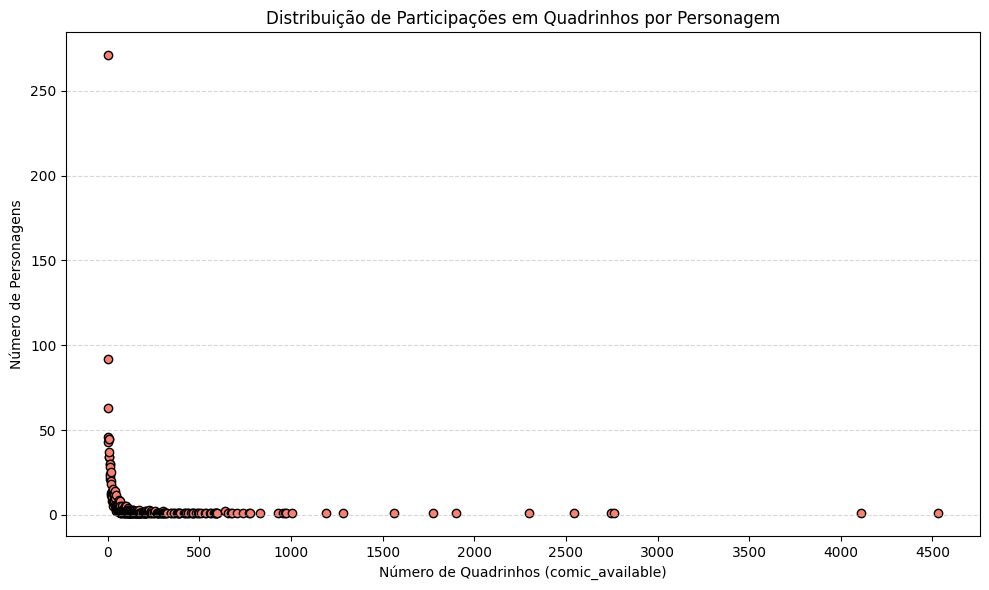

In [41]:
df_char['comic_available'] = pd.to_numeric(df_char['comic_available'], errors='coerce')
df_counts = df_char['comic_available'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.scatter(df_counts.index, df_counts.values, color='salmon', edgecolor='black')
plt.title('Distribuição de Participações em Quadrinhos por Personagem')
plt.xlabel('Número de Quadrinhos (comic_available)')
plt.ylabel('Número de Personagens')
step = 500
x_max = df_counts.index.max()
plt.xticks(range(0, int(x_max)+1, step))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [28]:
df_char['modified'] = pd.to_datetime(df_char['modified'])
df_recente = df_char.sort_values('modified', ascending=False)
df_recente.head(10)

,id,name,description,modified,comic_available
985,1011048,Greycrow (Greycrow),,2025-02-21 12:58:24+00:00,28
376,1009550,Bart Rozum,,2024-10-21 15:32:30+00:00,2
1071,1011136,Air-Walker (Gabriel Lan),,2024-09-24 11:11:31+00:00,4
332,1009502,Pretty Boy,,2024-08-06 15:36:21+00:00,3
1261,1011330,Revanche,,2024-08-06 15:33:37+00:00,1
1244,1011313,Ender Wiggin,,2024-07-24 10:57:24+00:00,13
99,1009250,Countess,,2024-07-24 10:56:39+00:00,4
531,1009713,Debra Whitman,,2024-07-24 10:55:56+00:00,3
1534,1017476,Kitty Pryde (X-Men: Battle of the Atom),,2024-07-24 10:55:25+00:00,2
1076,1011141,Cerise,,2024-07-24 10:54:55+00:00,4


In [61]:
# Ordena do mais recente para o mais antigo
df_recente = df_char.sort_values('modified', ascending=False)

# Mostra os 10 personagens mais recentemente modificados
df_recente[['name', 'modified']].head(10)


,0
name,Greycrow (Greycrow)Bart RozumAir-Walker (Gabri...
modified,2025-02-21T12:58:24+00002024-10-21T15:32:30+00...


In [53]:
# Garante que 'description' está tratada corretamente
df_char['description'] = df_char['description'].fillna('').astype(str).str.strip()

# Filtra personagens sem descrição
df_sem_descricao = df_char[df_char['description'] == '']

# Converte 'modified' para datetime e ordena
qtd_sem_descricao = df_sem_descricao.shape[0]
qtd_sem_descricao


1259

In [52]:
df_char['comic_available'].sum()

np.int64(101757)

In [65]:
101757/100

1017.57

In [91]:
arara = req('characters/1009610/comics',2)
arara2 = req('characters/1009610',2)

In [92]:
arara

{'code': 200,
 'status': 'Ok',
 'copyright': '© 2025 MARVEL',
 'attributionText': 'Data provided by Marvel. © 2025 MARVEL',
 'attributionHTML': '<a href="http://marvel.com">Data provided by Marvel. © 2025 MARVEL</a>',
 'etag': '34fb4a04e5b0a710af3bea0f6f52fc809b2b1622',
 'data': {'offset': 0,
  'limit': 2,
  'total': 4540,
  'count': 2,
  'results': [{'id': 1308,
    'digitalId': 0,
    'title': 'MARVEL AGE SPIDER-MAN: EVERYDAY HERO (Digest)',
    'issueNumber': 0,
    'variantDescription': '',
    'description': '',
    'modified': '-0001-11-30T00:00:00+0000',
    'isbn': '0-7851-1451-3',
    'upc': '5960611451-00111',
    'diamondCode': '',
    'ean': '',
    'issn': '',
    'format': 'Digest',
    'pageCount': 96,
    'textObjects': [{'type': 'issue_solicit_text',
      'language': 'en-us',
      'text': '"The Marvel Age of Comics continues! This time around, Spidey meets his match against such classic villains as Electro and the Lizard, and faces the return of one of his first foes

In [90]:
arara2

{'code': 200,
 'status': 'Ok',
 'copyright': '© 2025 MARVEL',
 'attributionText': 'Data provided by Marvel. © 2025 MARVEL',
 'attributionHTML': '<a href="http://marvel.com">Data provided by Marvel. © 2025 MARVEL</a>',
 'etag': '42b3a0e2c03c4caf093c1f2219fc6f2ca3de6715',
 'data': {'offset': 0,
  'limit': 2,
  'total': 1,
  'count': 1,
  'results': [{'id': 1009368,
    'name': 'Iron Man',
    'description': 'Wounded, captured and forced to build a weapon by his enemies, billionaire industrialist Tony Stark instead created an advanced suit of armor to save his life and escape captivity. Now with a new outlook on life, Tony uses his money and intelligence to make the world a safer, better place as Iron Man.',
    'modified': '2016-09-28T12:08:19+0000',
    'thumbnail': {'path': 'http://i.annihil.us/u/prod/marvel/i/mg/9/c0/527bb7b37ff55',
     'extension': 'jpg'},
    'resourceURI': 'https://gateway.marvel.com/v1/public/characters/1009368',
    'comics': {'available': 2745,
     'collection